# Simple Classification<a class="tocSkip">
&copy; 2020 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 27 July 2020
    
Requires presence of features.csv in thee same directory as this notebook.  That file should contain "features"
extracted from raw data by a prior step in the process (ex: Feature_Extraction_Using_Pandas).

Computed feature types can include things like: min, max, mean, std, variance, skew factor, kurtosis and sum.  
The list of possible feature types is literally unlimited.

# Import standard Models

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture, svm, metrics
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [14]:
# set default font for charts
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Read CSV file
Read features.csv, shuffles it and then break that data into separate features and results dataFrames.  Then display the first few lines of the shuffled dataset.

In [15]:
fn = 'features.csv'
data = pd.read_csv(fn)
print('Data shape retreived from the features data file is: ', str(data.shape))

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

display(data.head())

Data shape retreived from the features data file is:  (262, 33)


,maxAudio_max,acc_max,mag_max,gyro_max,maxAudio_min,acc_min,mag_min,gyro_min,maxAudio_skew,acc_skew,...,gyro_mean,maxAudio_std,acc_std,mag_std,gyro_std,maxAudio_var,acc_var,mag_var,gyro_var,class
0,395.0,1.10290,197.3150,4.75512,250.0,0.912562,54.6493,4.09236,-0.272337,-0.269098,...,4.38684,46.2235,0.064219,56.538200,0.250672,2136.610,4.124100e-03,3196.570000,0.062836,3.0
1,395.0,1.10821,106.9840,5.15419,223.0,0.912738,56.0798,4.19406,0.522063,0.829461,...,4.60501,65.3299,0.067129,19.815100,0.295387,4268.000,4.506260e-03,392.639000,0.087254,3.0
2,55.0,1.00057,78.2191,4.61307,-1.0,0.998912,77.5322,4.32297,-0.174508,0.068734,...,4.46503,19.6023,0.000596,0.237840,0.105089,384.250,3.556150e-07,0.056568,0.011044,0.0
3,59.0,1.00064,78.0864,4.82850,-1.0,0.999185,77.1325,4.61268,0.344410,0.151840,...,4.71279,18.4557,0.000495,0.319057,0.082483,340.611,2.450680e-07,0.101797,0.006803,0.0
4,220.0,1.06366,137.2140,4.89585,97.0,0.923464,53.6676,4.49419,-0.674985,-0.291327,...,4.65915,37.4303,0.053758,26.046500,0.135967,1401.030,2.889940e-03,678.420000,0.018487,2.0


In [16]:
f2 = 'acc_std'
f1 = 'maxAudio_sum'
# Split out features and class membership into separate tables.
features = data[[f1, f2]]
results=data['class'].astype(int)

# Split data into training and test sets

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(features.to_numpy(), results.to_numpy(), test_size=0.33, random_state=37)


# Subroutine for XY plots: myScatter()
This utility function can create an XY plot of two features found in the input table.  We use it here to reproduce a figure originally created by the Feature_Extraction_Using_Pandas notebook used to create our test features.csv.

This particular function works with numpy arrays only.  Contrast that with myScatterPandas (found in other notebooks in this series) which expects a Pandas dataframe as input.

Unnormalized input data


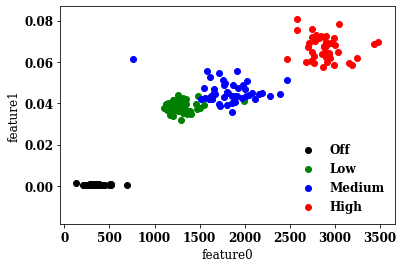

In [18]:
def myScatter(X, idx0, idx1, Y):
    labels=['Off', 'Low', 'Medium', 'High']
    color = ['black', 'green', 'blue', 'red']
    fig, ax = plt.subplots()
    x0 = X[:,idx0]
    x1 = X[:,idx1]
    for g in np.unique(Y):
        ix = np.where(g==Y)
        c=color[g]
        ax.scatter(x0[ix], x1[ix], c=c, label=labels[g])
    plt.legend(loc='best', frameon=False, labels=['Off', 'Low', 'Medium', 'High'])
    plt.xlabel('feature'+str(idx0))
    plt.ylabel('feature'+str(idx1))

print('Unnormalized input data')
myScatter(X_train, 0, 1, Y_train)


# Normalize input data
This next cell utilizes a scikit-Learn StandardScaler module.  It is FIT ONLY on the training data, but applies to both training and test data.  This distinction is required to avoid data snooping issues.

Normalized Training Set


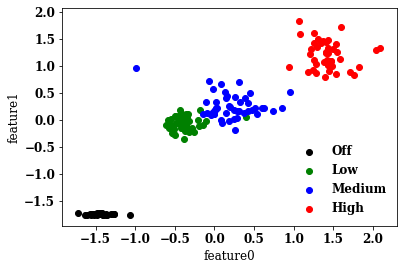

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
print('Normalized Training Set')
myScatter(X_train, 0, 1, Y_train)

Normalized Test Set


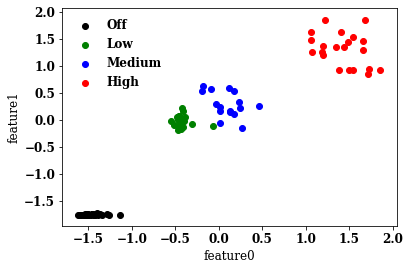

In [20]:
print('Normalized Test Set')
myScatter(X_test, 0, 1, Y_test)

# Train a model
We've included three classifier options here: multilayer perceptron, AdaBoost Classifier which uses max 2-deep decision
trees as base estimators, and LogisticRegression.  Choose mt=1, 2 or 3 to select which one you want to run.

In [31]:
mt = 1

if mt==1:
    model = MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, alpha=1e-4,
                        solver='sgd', verbose=10, random_state=1,
                        learning_rate_init=.1, batch_size=10, shuffle=True)
elif mt==2:
    n_estimators=50
    model=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                             algorithm="SAMME", n_estimators=n_estimators, random_state=777)
elif mt==3:
    model=LogisticRegression(C=1)   

model.fit(X_train, Y_train)

print("Test set score: %f" % model.score(X_train, Y_train))
print("Test set score: %f" % model.score(X_test, Y_test))

Iteration 1, loss = 1.08839037
Iteration 2, loss = 0.38911617
Iteration 3, loss = 0.16721809
Iteration 4, loss = 0.10954986
Iteration 5, loss = 0.10185712
Iteration 6, loss = 0.08387628
Iteration 7, loss = 0.07884689
Iteration 8, loss = 0.08133424
Iteration 9, loss = 0.06873508
Iteration 10, loss = 0.06350191
Iteration 11, loss = 0.06016524
Iteration 12, loss = 0.05852979
Iteration 13, loss = 0.06087814
Iteration 14, loss = 0.05461004
Iteration 15, loss = 0.06165417
Iteration 16, loss = 0.06535197
Iteration 17, loss = 0.05335130
Iteration 18, loss = 0.05538367
Iteration 19, loss = 0.05526034
Iteration 20, loss = 0.05741539
Iteration 21, loss = 0.06001010
Iteration 22, loss = 0.05752655
Iteration 23, loss = 0.05485559
Iteration 24, loss = 0.05781469
Iteration 25, loss = 0.05388607
Iteration 26, loss = 0.05383938
Iteration 27, loss = 0.05080443
Iteration 28, loss = 0.05377555
Iteration 29, loss = 0.05579510
Iteration 30, loss = 0.05146496
Iteration 31, loss = 0.05022082
Iteration 32, los

# Now look at the confusion matrices
## Training Confusion Matrix

Confusion matrix for the training set


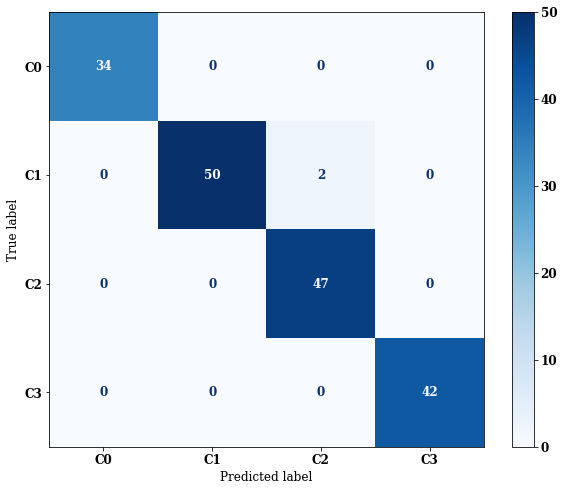

In [32]:
names = ['C0', 'C1', 'C2', 'C3']
fig, ax = plt.subplots(1, 1, figsize=(10,8))
print('Confusion matrix for the training set')
cm1=metrics.plot_confusion_matrix(model, X_train, Y_train, ax=ax, display_labels=names, cmap=plt.cm.Blues, values_format='n')

## Test Confusion Matrix

Confusion matrix for the test set


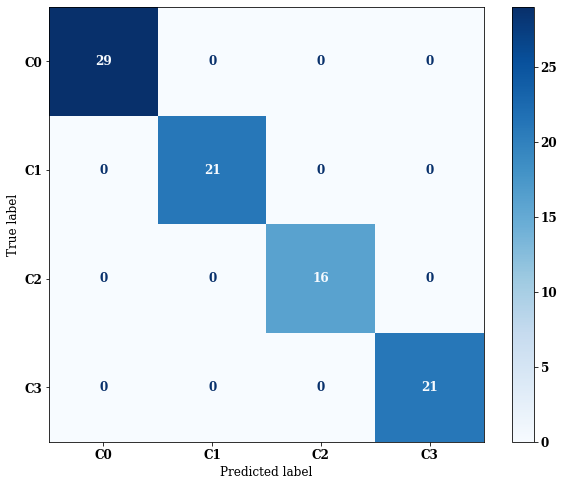

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
print('Confusion matrix for the test set')
cm2=metrics.plot_confusion_matrix(model, X_test, Y_test, ax=ax, display_labels=names, cmap=plt.cm.Blues, values_format='n')